In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torchvision
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import ToTensor
import math
from tqdm import tqdm
import math, matplotlib.pyplot as plt
from torch.distributions.normal import Normal

In [2]:
print(torch.__version__, torchvision.__version__)
print("cuda available:", torch.cuda.is_available())
print("cudnn version:", torch.backends.cudnn.version())
# Get device name
if torch.cuda.is_available():
    print("Device name:", torch.cuda.get_device_name(0))

2.8.0+cu128 0.23.0+cu128
cuda available: True
cudnn version: 91002
Device name: NVIDIA GeForce RTX 2060


In [127]:
torch.set_default_dtype(torch.float64)
#device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [128]:
class Net(torch.nn.Module):
    def __init__(self, d_in = 1, d_hidden = 20):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(d_in, d_hidden), torch.nn.Softplus(),
            torch.nn.Linear(d_hidden, d_hidden), torch.nn.Softplus(),
            torch.nn.Linear(d_hidden, d_hidden), torch.nn.Softplus(),
            torch.nn.Linear(d_hidden, d_hidden), torch.nn.Softplus(),
            torch.nn.Linear(d_hidden, 1)
        )
    def forward(self, x):  # x: [B,1] -> [B,1]
        return self.mlp(x)

net = Net(d_in = 1, d_hidden = 20).to(device)
opt = torch.optim.AdamW(net.parameters(), lr=1e-3, weight_decay=0.0)
mse = torch.nn.MSELoss()
lam = 3.0

In [ ]:
def sample_S0_batch(B, mean=100., std=25., device=device):
    # Could be any distribution over S0; lognormal or normal > 0
    S0 = torch.clamp(torch.randn(B,1,device=device)*std + mean, min=1e-3)
    return S0

### OLD VERSION

# def bs_batch(S0_batch: torch.Tensor, K: float, r: float, sigma: float, dt: float, device=None, anti = True):
#     """
#     Vectorized version.
#     Args:
#       S0_batch: shape [B, 1] or [B], positive spots
#     Returns:
#       y:      [B, 1] payoffs
#       dydS:   [B, 1] pathwise differentials wrt S0
#     """
#     if device is None: device = S0_batch.device
#     S0 = S0_batch.view(-1, 1)
#     B  = S0.shape[0]
#     Z  = torch.randn(B, 1, device=device)
#     log_factor = (r - 0.5 * sigma**2) * dt + sigma * math.sqrt(dt) * Z
#     ST = S0 * torch.exp(log_factor)
#     y = torch.clamp(ST - K, min=0.0)

#     dydS = (ST > K).float() * (ST / S0)  # pathwise delta

#     if anti:
#         # antithetic variates
#         ST2 = S0 * torch.exp((r - 0.5 * sigma**2) * dt - sigma * math.sqrt(dt) * Z)
#         y2 = torch.clamp(ST2 - K, min=0.0)
#         y = 0.5 * (y + y2)

#         dydS2 = (ST2 > K).float() * (ST2 / S0)
#         dydS = 0.5 * (dydS + dydS2)

#     return y, dydS

In [ ]:
def bs_batch(
    S0_batch: torch.Tensor,
    K: float, r: float, sigma: float, dt: float,
    device=None,
    anti: bool = True,
    discount: bool = True,
):
    """
    Returns:
      y:    [B,1] payoffs (possibly discounted, antithetic-averaged)
      dydS: [B,1] pathwise dY/dS0 (same discounting (should maybe not discount) + antithetic averaging)
    """
    if device is None:
        device = S0_batch.device
    S0 = S0_batch.view(-1, 1)
    B  = S0.shape[0]

    Z  = torch.randn(B, 1, device=device)
    drift = (r - 0.5 * sigma**2) * dt
    vol   = sigma * math.sqrt(dt)

    # +Z path
    ST1 = S0 * torch.exp(drift + vol * Z)
    Y1  = torch.clamp(ST1 - K, min=0.0)
    G1  = (ST1 > K).float() * (ST1 / S0)   # dY/dS0 for +Z

    if anti:
        # -Z path
        ST2 = S0 * torch.exp(drift - vol * Z)
        Y2  = torch.clamp(ST2 - K, min=0.0)
        G2  = (ST2 > K).float() * (ST2 / S0)  # dY/dS0 for -Z

        Y   = 0.5 * (Y1 + Y2)
        G   = 0.5 * (G1 + G2)
    else:
        Y, G = Y1, G1

    if discount:
        disc = torch.exp(torch.tensor(-r*dt, device=device))
        Y = Y * disc
        G = G * disc  # constant factor; keeps price–delta internally consistent

    return Y, G

In [192]:
# running mean/std for online normalization (simple EMA)
x_mu = torch.zeros(1,1, device=device); x_sd = torch.ones(1,1, device=device)
y_mu = torch.zeros(1,1, device=device); y_sd = torch.ones(1,1, device=device)
alpha = 0.01  # EMA smoothing

def norm_update(x, y):
    global x_mu, x_sd, y_mu, y_sd
    with torch.no_grad():
        xb_mu = x.mean(dim=0, keepdim=True)
        xb_sd  = x.std(dim=0, keepdim=True) + 1e-6
        yb_mu = y.mean(dim=0, keepdim=True)
        yb_sd = y.std(dim=0, keepdim=True) + 1e-6
        x_mu = (1-alpha)*x_mu + alpha*xb_mu
        x_sd = (1-alpha)*x_sd + alpha*xb_sd
        y_mu = (1-alpha)*y_mu + alpha*yb_mu
        y_sd = (1-alpha)*y_sd + alpha*yb_sd

def norm_x(x): return (x - x_mu) / x_sd
def norm_y(y): return (y - y_mu) / y_sd

In [ ]:
# fixed contract/params
K, r, sigma, dt = 110.0, 0.00, 0.2, 1.0

for _ in range(20):
    S0 = sample_S0_batch(B=8192*4)
    y, _ = bs_batch(S0, K, r, sigma, dt, device=device, anti=True, discount=False)
    # Discount here to match standard BS PV
    y = y * torch.exp(torch.tensor(-r*dt, device=device))
    norm_update(S0, y)

In [ ]:
steps = 500
pbar = tqdm(range(steps), desc="Training", ncols=100)
for step in pbar:
    S0 = sample_S0_batch(B=1024)
    y, dydS = bs_batch(S0, K, r, sigma, dt, device=device, anti=True, discount=False)
    # Discount the payoff; delta unchanged? (since it's wrt S0)?
    y = y * torch.exp(torch.tensor(-r*dt, device=device))

    # update running stats
    norm_update(S0, y)

    # scale gradient labels for normalized coordinates
    grad_scale = (x_sd / y_sd).detach()
    dydx_norm = dydS * grad_scale  # [B,1]

    # gentle lambda ramp: approx 0 -> 1 over first steps/2 steps
    lamda = 1.0 * min(step/(steps/2), 1.0)

    # forward
    xhat = norm_x(S0).requires_grad_(True)     # [B,1]
    yhat_norm = net(xhat).squeeze(-1)          # [B]
    y_norm = norm_y(y).squeeze(-1)             # [B]

    # autograd wrt normalized input
    dyhat_dxhat = torch.autograd.grad(yhat_norm.sum(), xhat, create_graph=True)[0].squeeze(-1)

    loss = mse(yhat_norm, y_norm) + lamda * mse(dyhat_dxhat, dydx_norm.squeeze(-1))

    opt.zero_grad()
    loss.backward()
    opt.step()

    if (step+1) % 20 == 0:
        pbar.set_postfix(loss=float(loss))

Training: 100%|██████████████████████████████████████| 500/500 [00:03<00:00, 140.98it/s, loss=0.414]


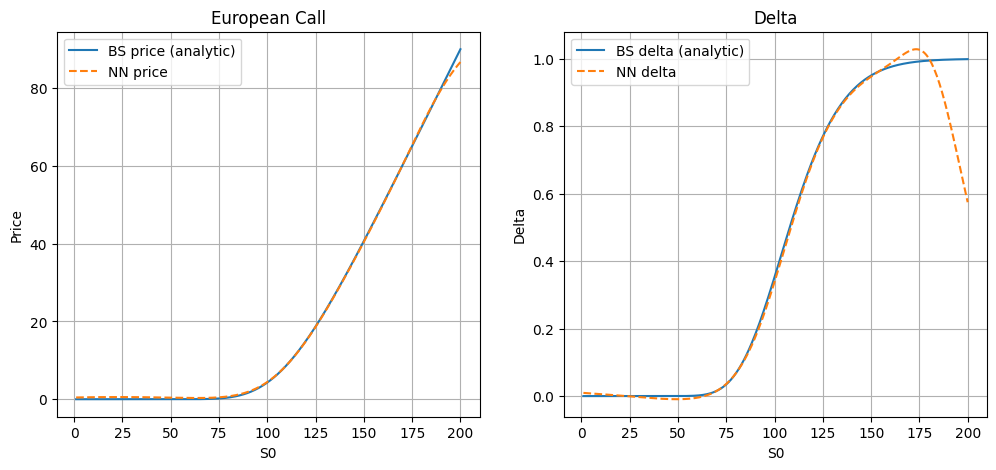

RMSE price=0.5332  RMSE delta=0.0736


In [208]:
def bs_price_delta_discounted(S, K, r, sigma, T):
    S = torch.as_tensor(S, dtype=torch.float32, device=device)
    std = sigma * math.sqrt(T)
    d1  = (torch.log(S / K) + (r + 0.5*sigma**2) * T) / std
    d2  = d1 - std
    Phi = Normal(0.,1.).cdf
    price = S*Phi(d1) - K*torch.exp(torch.tensor(-r*T, device=device))*Phi(d2)
    delta = Phi(d1)
    return price, delta

# grid
S0_grid = torch.linspace(1.0, 200.0, 300, device=device).view(-1,1)

# ground truth (DISCOUNTED)
with torch.no_grad():
    price_true, delta_true = bs_price_delta_discounted(S0_grid, K, r, sigma, dt)

# model predictions in ORIGINAL units
xhat = ((S0_grid - x_mu) / x_sd).detach().clone().requires_grad_(True)
yhat_norm = net(xhat)                                   # [B,1] or [B]
dyhat_dxhat = torch.autograd.grad(yhat_norm.sum(), xhat, create_graph=False)[0]  # [B,1]

price_pred = y_mu + y_sd * yhat_norm                    # de-normalized price
delta_pred = (y_sd / x_sd) * dyhat_dxhat                # de-normalized delta

# plot
S = S0_grid.detach().cpu().view(-1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(S, price_true.detach().cpu().view(-1), label='BS price (analytic)')
plt.plot(S, price_pred.detach().cpu().view(-1), '--', label='NN price')
plt.xlabel('S0'); plt.ylabel('Price'); plt.title('European Call'); plt.grid(); plt.legend()

plt.subplot(1,2,2)
plt.plot(S, delta_true.detach().cpu().view(-1), label='BS delta (analytic)')
plt.plot(S, delta_pred.detach().cpu().view(-1), '--', label='NN delta')
plt.xlabel('S0'); plt.ylabel('Delta'); plt.title('Delta'); plt.grid(); plt.legend()
plt.show()

# quick metrics
rmse_price = torch.sqrt(((price_pred - price_true)**2).mean()).item()
rmse_delta = torch.sqrt(((delta_pred - delta_true)**2).mean()).item()
print(f"RMSE price={rmse_price:.4f}  RMSE delta={rmse_delta:.4f}")
